# 08 - K-Nearest Neighbors Classifier

by [Alejandro Correa Bahnsen](albahnsen.com/)

version 0.1, Mar 2016

## Part of the class [Practical Machine Learning](https://github.com/albahnsen/PracticalMachineLearningClass)



This notebook is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). Special thanks goes to [Kevin Markham](https://github.com/justmarkham), [Scikit-learn docs](http://scikit-learn.org/) & [Jason Brownlee](http://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/)

## K-Nearest Neighbors

The model for kNN is the entire training dataset. When a prediction is required for a unseen data instance, the kNN algorithm will search through the training dataset for the k-most similar instances. The prediction attribute of the most similar instances is summarized and returned as the prediction for the unseen instance.

The similarity measure is dependent on the type of data. For real-valued data, the Euclidean distance can be used. Other other types of data such as categorical or binary data, Hamming distance can be used.

In the case of regression problems, the average of the predicted attribute may be returned. In the case of classification, the most prevalent class may be returned.

## How does k-Nearest Neighbors Work

The kNN algorithm is belongs to the family of instance-based, competitive learning and lazy learning algorithms.

Instance-based algorithms are those algorithms that model the problem using data instances (or rows) in order to make predictive decisions. The kNN algorithm is an extreme form of instance-based methods because all training observations are retained as part of the model.

It is a competitive learning algorithm, because it internally uses competition between model elements (data instances) in order to make a predictive decision. The objective similarity measure between data instances causes each data instance to compete to “win” or be most similar to a given unseen data instance and contribute to a prediction.

Lazy learning refers to the fact that the algorithm does not build a model until the time that a prediction is required. It is lazy because it only does work at the last second. This has the benefit of only including data relevant to the unseen data, called a localized model. A disadvantage is that it can be computationally expensive to repeat the same or similar searches over larger training datasets.

Finally, kNN is powerful because it does not assume anything about the data, other than a distance measure can be calculated consistently between any two instances. As such, it is called non-parametric or non-linear as it does not assume a functional form.

## Example using the iris dataset

In [1]:
# read the iris data into a DataFrame
import pandas as pd
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

In [2]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Human learning on the iris dataset

How did we (as humans) predict the species of an iris?

1. We observed that the different species had (somewhat) dissimilar measurements.
2. We focused on features that seemed to correlate with the response.
3. We created a set of rules (using those features) to predict the species of an unknown iris.

We assumed that if an **unknown iris** has measurements similar to **previous irises**, then its species is most likely the same as those previous irises.

In [3]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

# create a custom colormap
from matplotlib.colors import ListedColormap
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

In [4]:
# map each iris species to a number
iris['species_num'] = iris.species.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})

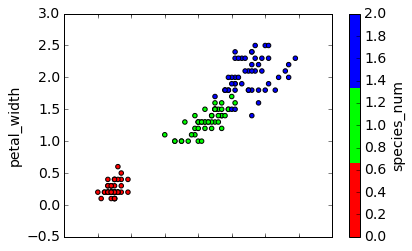

In [5]:
# create a scatter plot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
iris.plot(kind='scatter', x='petal_length', y='petal_width', c='species_num', colormap=cmap_bold)

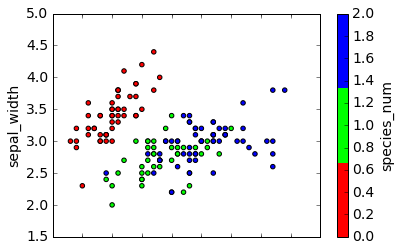

In [6]:
# create a scatter plot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES
iris.plot(kind='scatter', x='sepal_length', y='sepal_width', c='species_num', colormap=cmap_bold)

## Creating a KNN classifier

### Estimate Similarity 

In order to make predictions we need to calculate the similarity between any two given data instances. This is needed so that we can locate the k most similar data instances in the training dataset for a given member of the test dataset and in turn make a prediction.

Given that all four flower measurements are numeric and have the same units, we can directly use the Euclidean distance measure. This is defined as the square root of the sum of the squared differences between the two arrays of numbers (read that again a few times and let it sink in).

Additionally, we want to control which fields to include in the distance calculation. Specifically, we only want to include the first 4 attributes. One approach is to limit the euclidean distance to a fixed length, ignoring the final dimension.

Putting all of this together we can define the `euclideanDistance` function as follows:

In [7]:
import numpy as np
def euclideanDistance(instance1, instance2):
    distance = (instance1 - instance2) ** 2
    
    # Check if either instance1 or instance2 is a matrix
    if distance.shape[0] == distance.size:
        return distance.sum() ** 0.5
    else:
        return distance.sum(axis=1) ** 0.5

In [8]:
data1 = np.array([2, 2])
data2 = np.array([4, 4])
distance = euclideanDistance(data1, data2)
print('Distance: ' + repr(distance))

Distance: 2.8284271247461903


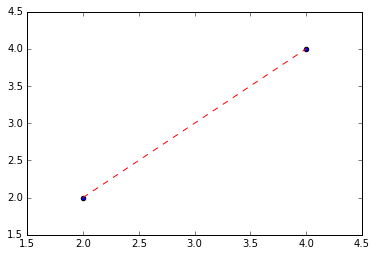

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(data1[0], data1[1])
plt.scatter(data2[0], data2[1])
plt.plot([data1[0], data2[0]], [data1[1], data2[1]], '--r')

### Find Neighbors

Now that we have a similarity measure, we can use it collect the k most similar instances for a given unseen instance.

This is a straight forward process of calculating the distance for all instances and selecting a subset with the smallest distance values.

Below is the `getNeighbors` function that returns k most similar neighbors from the training set for a given test instance (using the already defined `euclideanDistance` function)

In [10]:
trainSet = np.array([[2, 2], [4, 4], [7, 7], [4, 1], [3, 4], [5, 2]])
testInstance = np.array([5, 5])

In [11]:
dist = euclideanDistance(trainSet, testInstance)
dist

array([ 4.24264069,  1.41421356,  2.82842712,  4.12310563,  2.23606798,  3.        ])

Which are the closest two points

In [12]:
dist.argsort()[:2]

array([1, 4])

In [13]:
def getNeighbors(trainSet, testInstance, k):
    dist = euclideanDistance(trainSet, testInstance)
    neighbors = dist.argsort()[:k]
    return neighbors

In [14]:
k = 1
neighbors = getNeighbors(trainSet, testInstance, k)
print(neighbors)

[1]


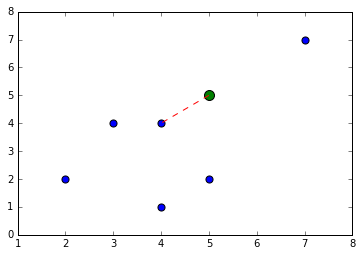

In [15]:
plt.scatter(trainSet[:, 0], trainSet[:, 1], s=50)
plt.scatter(testInstance[0], testInstance[1], c='green', s=100)
plt.plot([testInstance[0], trainSet[1, 0]], [testInstance[1], trainSet[1, 1]], '--r')

In [16]:
testInstance = np.array([3.4, 3])
k = 3
neighbors = getNeighbors(trainSet, testInstance, k)
print(neighbors)

[4 1 0]


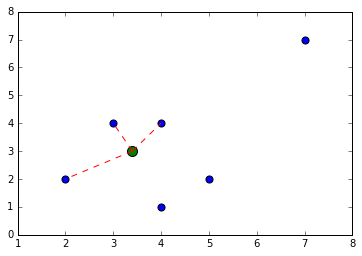

In [17]:
plt.scatter(trainSet[:, 0], trainSet[:, 1], s=50)
plt.scatter(testInstance[0], testInstance[1], c='green', s=100)
for neighbor in neighbors:
    plt.plot([testInstance[0], trainSet[neighbor, 0]], [testInstance[1], trainSet[neighbor, 1]], '--r')

### Response

Once we have located the most similar neighbors for a test instance, the next task is to devise a predicted response based on those neighbors.

We can do this by allowing each neighbor to vote for their class attribute, and take the majority vote as the prediction.

Lets first define the label of each instance.

In [18]:
trainSet_y = np.array([0, 0, 1, 0, 1, 1])

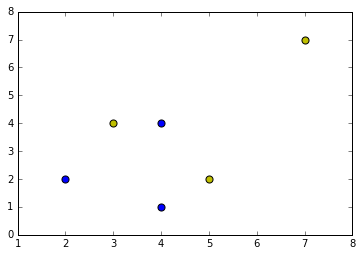

In [19]:
plt.scatter(trainSet[trainSet_y==0, 0], trainSet[trainSet_y==0, 1], s=50)
plt.scatter(trainSet[trainSet_y==1, 0], trainSet[trainSet_y==1, 1], c='y', s=50)

Below provides a function for getting the majority voted response from a number of neighbors. It assumes the class is the last attribute for each neighbor.

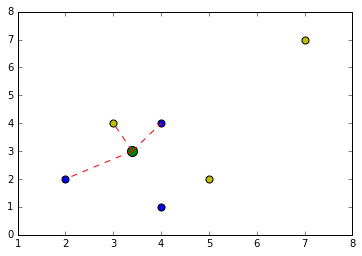

In [20]:
plt.scatter(trainSet[trainSet_y==0, 0], trainSet[trainSet_y==0, 1], s=50)
plt.scatter(trainSet[trainSet_y==1, 0], trainSet[trainSet_y==1, 1], c='y', s=50)
plt.scatter(testInstance[0], testInstance[1], c='green', s=100)
for neighbor in neighbors:
    plt.plot([testInstance[0], trainSet[neighbor, 0]], [testInstance[1], trainSet[neighbor, 1]], '--r')

In [21]:
trainSet_y[neighbors]

array([1, 0, 0])

In [22]:
from scipy.stats import itemfreq
freq = itemfreq(trainSet_y[neighbors])
freq

array([[0, 2],
       [1, 1]])

In [23]:
freq[:, 1].argmax()

0

In [24]:
freq[:, 0][freq[:, 1].argmax()]

0

### Estimate probaliy

Similarly, the probabily can be estimated as the percentage of neighbor's voting for each class

In [25]:
freq[:, 1] / freq[:, 1].sum()

array([ 0.66666667,  0.33333333])

In [26]:
np.vstack((freq[:, 0], freq[:, 1] / freq[:, 1].sum())).T

array([[ 0.        ,  0.66666667],
       [ 1.        ,  0.33333333]])

### creating the response

In [27]:
def getResponse(trainSet_y, neighbors):
    votes = trainSet_y[neighbors]
    freq = itemfreq(votes)
    return freq[:, 0][freq[:, 1].argmax()], np.vstack((freq[:, 0], freq[:, 1] / freq[:, 1].sum())).T

We can test out this function with some test neighbors, as follows:

In [28]:
response = getResponse(trainSet_y, neighbors)
print(response)

(0, array([[ 0.        ,  0.66666667],
       [ 1.        ,  0.33333333]]))


### Classifier

Lets put everything together

In [29]:
def knn_classifier_one(trainSet, trainSet_y, testInstance, k):
    neighbors = getNeighbors(trainSet, testInstance, k)
    pred_y, pred_prob = getResponse(trainSet_y, neighbors)
    return pred_y, pred_prob, neighbors

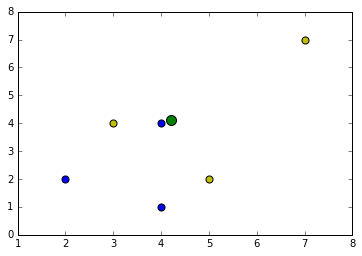

In [30]:
testInstance = np.array([4.2, 4.1])
plt.scatter(trainSet[trainSet_y==0, 0], trainSet[trainSet_y==0, 1], s=50)
plt.scatter(trainSet[trainSet_y==1, 0], trainSet[trainSet_y==1, 1], c='y', s=50)
plt.scatter(testInstance[0], testInstance[1], c='green', s=100)

k =  2
pred_y =  0
pred_prob =  [[ 0.   0.5]
 [ 1.   0.5]]


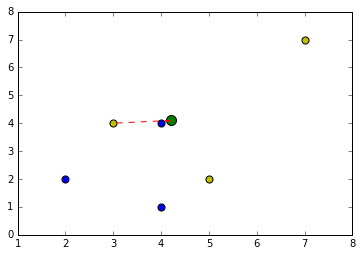

k =  3
pred_y =  1
pred_prob =  [[ 0.          0.33333333]
 [ 1.          0.66666667]]


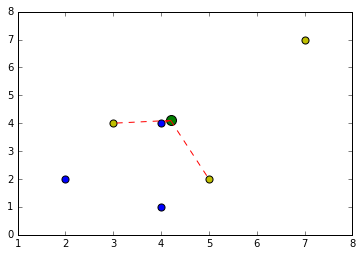

k =  4
pred_y =  0
pred_prob =  [[ 0.   0.5]
 [ 1.   0.5]]


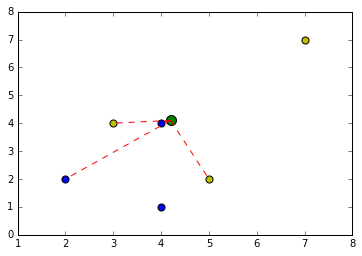

k =  5
pred_y =  0
pred_prob =  [[ 0.   0.6]
 [ 1.   0.4]]


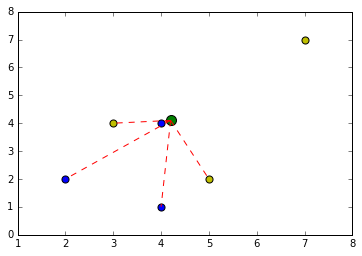

In [31]:
for k in range(2, 6):
    print('k = ', k)
    pred_y, pred_prob, neighbors = knn_classifier_one(trainSet, trainSet_y, testInstance, k)
    print('pred_y = ', pred_y)
    print('pred_prob = ', pred_prob)
    plt.scatter(trainSet[trainSet_y==0, 0], trainSet[trainSet_y==0, 1], s=50)
    plt.scatter(trainSet[trainSet_y==1, 0], trainSet[trainSet_y==1, 1], c='y', s=50)
    plt.scatter(testInstance[0], testInstance[1], c='green', s=100)
    for neighbor in neighbors:
        plt.plot([testInstance[0], trainSet[neighbor, 0]], [testInstance[1], trainSet[neighbor, 1]], '--r')
    plt.show()

### Allow more than one instances

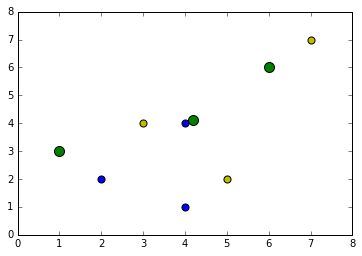

In [32]:
testInstances = np.array([[4.2, 4.1], [1, 3], [6, 6]])
plt.scatter(trainSet[trainSet_y==0, 0], trainSet[trainSet_y==0, 1], s=50)
plt.scatter(trainSet[trainSet_y==1, 0], trainSet[trainSet_y==1, 1], c='y', s=50)
plt.scatter(testInstances[:,0], testInstances[:,1], c='green', s=100)

In [33]:
def knn_classifier(trainSet, trainSet_y, testInstances, k):
    n_samples_test = testInstances.shape[0]
    pred_y = np.zeros(n_samples_test)
    y_unique = np.unique(trainSet_y)
    pred_prob = np.zeros((n_samples_test, y_unique.shape[0]))
    for i in range(n_samples_test):
        neighbors = getNeighbors(trainSet, testInstances[i], k)
        pred_y_, pred_prob_ = getResponse(trainSet_y, neighbors)
        pred_y[i] = pred_y_
        
        # pred_y may not include all values of y
        for j in range(y_unique.shape[0]):
            pred_prob[i, j] =  pred_prob_[pred_prob_[:,0] == y_unique[j], 1].sum()
            
    return pred_y, pred_prob

In [34]:
k = 3
knn_classifier(trainSet, trainSet_y, testInstances, k)

(array([ 1.,  0.,  1.]), array([[ 0.33333333,  0.66666667],
        [ 0.66666667,  0.33333333],
        [ 0.33333333,  0.66666667]]))

## Apply to Iris dataset

In [35]:
y = iris.species_num
X = iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]

In [36]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=123)

In [37]:
y_pred, y_pred_prob = knn_classifier(X_train, y_train, X_test, k=5)

In [38]:
y_pred_prob[:5]

array([[ 0. ,  0.4,  0.6],
       [ 0. ,  0. ,  1. ],
       [ 0. ,  0. ,  1. ],
       [ 0. ,  1. ,  0. ],
       [ 1. ,  0. ,  0. ]])

In [39]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[16,  0,  0],
       [ 0,  7,  1],
       [ 0,  0, 14]])

## Using Sklearn

In [40]:
from sklearn.neighbors import KNeighborsClassifier

In [41]:
knn = KNeighborsClassifier(n_neighbors=5)

In [42]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [43]:
y_pred = knn.predict(X_test)
y_pred_prob = knn.predict_proba(X_test)

In [44]:
y_pred_prob[:5]

array([[ 0. ,  0.4,  0.6],
       [ 0. ,  0. ,  1. ],
       [ 0. ,  0. ,  1. ],
       [ 0. ,  1. ,  0. ],
       [ 1. ,  0. ,  0. ]])

In [45]:
confusion_matrix(y_test, y_pred)

array([[16,  0,  0],
       [ 0,  7,  1],
       [ 0,  0, 14]])

## Comparing KNN with other models

**Advantages of KNN:**

- Simple to understand and explain
- Model training is fast
- Can be used for classification and regression

**Disadvantages of KNN:**

- Must store all of the training data
- Prediction phase can be slow when n is large
- Sensitive to irrelevant features
- Sensitive to the scale of the data
- Accuracy is (generally) not competitive with the best supervised learning methods